Fault tolerance: There could be errors when checking for syndromes as well! We need to make sure that the errors that occur don't spread out too much and ruin the whole computation.

Ways of doing fault tolerant error correction
- Shor
- Steane
- Knill

Let's go with Knill for today

Defining our batteries..

In [28]:
import cirq
import sympy
import numpy as np

lq0_qubits = cirq.LineQubit.range(0, 7)
lq1_qubits = cirq.LineQubit.range(7, 14)
lq2_qubits = cirq.LineQubit.range(14, 21)
lq3_qubits = cirq.LineQubit.range(21, 28)
lq4_qubits = cirq.LineQubit.range(28, 35)
lq5_qubits = cirq.LineQubit.range(35, 42)
lq6_qubits = cirq.LineQubit.range(42, 49)

qubits = [lq0_qubits, lq1_qubits, lq2_qubits, lq3_qubits, lq4_qubits, lq5_qubits, lq6_qubits ]
sim = cirq.Simulator()

The Steane code gives us Transversal logical gates for H, X and CX

In [29]:
def transversal_h(qubits: list[cirq.LineQubit]):
    return cirq.H.on_each(qubits)
def transversal_x(qubits: list[cirq.LineQubit]):
    return cirq.X.on_each(qubits)
def transversal_cx(qubits0: list[cirq.LineQubit], qubits1: list[cirq.LineQubit]):
    return [cirq.CX(i, j) for i, j in zip(qubits0, qubits1)]

In [30]:
def encode(qubits: list[cirq.LineQubit]) -> cirq.Circuit:
    """
    Creates a (0>_{L}) for the Steane code
    ref: https://quantumcomputing.stackexchange.com/a/23346/362
    """
    encoding_circuit = cirq.Circuit(
        transversal_h(qubits[0]),
        transversal_h(qubits[1]),
        transversal_h(qubits[3]),
        transversal_cx([qubits[0]], [qubits[2]]),
        transversal_cx([qubits[3]], [qubits[5]]),
        transversal_cx([qubits[1]], [qubits[6]]),
        transversal_cx([qubits[0]], [qubits[4]]),
        transversal_cx([qubits[3]], [qubits[6]]),
        transversal_cx([qubits[1]], [qubits[5]]),
        transversal_cx([qubits[0]], [qubits[6]]),
        transversal_cx([qubits[1]], [qubits[2]]),
        transversal_cx([qubits[3]], [qubits[4]]),
    )
    return encoding_circuit

In [31]:
logical_circuit = encode(qubits[0])

In [32]:
logical_circuit

┌──┐   ┌───┐   ┌──┐
0: ───H────@──────@───────@─────
           │      │       │
1: ───H────┼@─────┼─@─────┼@────
           ││     │ │     ││
2: ────────X┼─────┼─┼─────┼X────
            │     │ │     │
3: ───H────@┼─────┼@┼─────┼@────
           ││     │││     ││
4: ────────┼┼─────X┼┼─────┼X────
           ││      ││     │
5: ────────X┼──────┼X─────┼─────
            │      │      │
6: ─────────X──────X──────X─────
          └──┘   └───┘   └──┘

If my bitstring is in the codespace of the steane code it will look like this. So any of the basis states of this state will be a |0> state

We can confirm that we have the correct $|0⟩_{L}$ state

In [34]:
def physical_measurements_to_logical_measurements(measurements: np.ndarray) -> int:
    ket_0 = [
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 1, 0, 0, 1, 1, 0],
        [1, 1, 0, 1, 0, 0, 1],
    ]
    # |1> is the opposite of |0>
    ket_1 = [[1 - bit for bit in state] for state in ket_0]
    list_measurements = list(measurements)
    if list_measurements in ket_0:
        return 0
    elif list_measurements in ket_1:
        return 1
    else:
        raise ValueError(
            f"Your logical state is outside the Steane encoding's subspace {measurements}"
        )

def qec_simulator(circuit: cirq.Circuit, repetitions: int) -> cirq.ResultDict:
    sim = cirq.CliffordSimulator()
    results = sim.run(circuit, repetitions=repetitions)
    new_result_dict = {}
    for key in results.measurements.keys():
        results_at_key = results.measurements[key]
        results_values = []
        for result in results_at_key:
            phys = physical_measurements_to_logical_measurements(result)
            results_values.append(phys)
        new_result_dict[key] = np.array([results_values])
    results = cirq.ResultDict(
        params=cirq.ParamResolver({}), measurements=new_result_dict
    )
    return results

In [35]:
inject_no_error =  encode(qubits[0]) + cirq.measure(qubits[0], key='m')

In [38]:
print(
qec_simulator(
        encode(qubits[0]) + cirq.measure(qubits[0], key='m'), 1
    )
)

m=0


In [39]:
inject_x_error =  encode(qubits[0]) + cirq.X(qubits[0][1]) + cirq.measure(qubits[0], key='m')

We can see that injecting an $X$ error can be detected from the measured bitstrings.

In [40]:
print(
    qec_simulator(
        encode(qubits[0]) + cirq.X(qubits[0][1]) + cirq.measure(qubits[0], key='m'), 10
    )
)

ValueError: Your logical state is outside the Steane encoding's subspace [0 1 0 0 0 0 0]

Stabilizers: The things you need to measure on a logical qubit to diagnose the error: also known as a parity-checks.
The stabilizers of the Steane code are. Use the picture and say that these stabilizers connect to the faces of the triangle :

```IIIXXXX

    IXXIIXX

    XIXIXIX

    IIIZZZZ

    IZZIIZZ

    ZIZIZIZ

In [43]:
def syndrome(measurements: list[int]) -> tuple[int, int, int]:
    s1 = measurements[3] ^ measurements[4] ^ measurements[5] ^ measurements[6]
    s2 = measurements[1] ^ measurements[2] ^ measurements[5] ^ measurements[6]
    s3 = measurements[0] ^ measurements[2] ^ measurements[4] ^ measurements[6]
    return s1, s2, s3

In [46]:
sim = cirq.Simulator()
results = sim.run(inject_x_error, repetitions=1)

In [47]:
results.measurements

{'m': array([[0, 1, 0, 0, 0, 0, 0]], dtype=int8)}

In [48]:
error = results.measurements[cirq.MeasurementKey(name='m')][0]
s = syndrome(error)
print(s)

(np.int8(0), np.int8(1), np.int8(0))


Based on the bit-string, flip the right bits to correct the errors

In [15]:
def correct_error(
    measurements: np.ndarray, syndrome_measurements: tuple[int, int, int]
):
    syndrome_to_index = {
        (0, 0, 1): 0,
        (0, 1, 0): 1,
        (0, 1, 1): 2,
        (1, 0, 0): 3,
        (1, 0, 1): 4,
        (1, 1, 0): 5,
        (1, 1, 1): 6,
    }

    if syndrome_measurements in syndrome_to_index:
        measurements[syndrome_to_index[syndrome_measurements]] ^= 1

    return measurements

Go into phase flips and bit flip errors but noththeless add examples here about how errors are detected and corrected

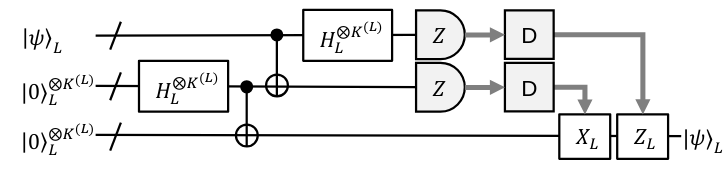

Image source: https://arxiv.org/abs/2403.16054

In [49]:
def common_resolve(classical_data: cirq.ClassicalDataStore, key_name: str) -> bool:
    error = list(classical_data._records[cirq.MeasurementKey(name=key_name)][0])
    s = syndrome(error)
    corrected_measurements = correct_error(error, s)
    classical_data._records[cirq.MeasurementKey(name=key_name)][0] = (
        corrected_measurements
    )
    phys = physical_measurements_to_logical_measurements(corrected_measurements)
    if phys == 1:
        return True
    elif phys == 0:
        return False


class ZCondition(cirq.KeyCondition):
    def resolve(self, classical_data: cirq.ClassicalDataStore) -> bool:
        return common_resolve(classical_data, "ancilla0")


class XCondition(cirq.KeyCondition):
    def resolve(self, classical_data: cirq.ClassicalDataStore) -> bool:
        return common_resolve(classical_data, "ancilla1")

In [50]:
def generate_logical_circuit(
    logical_gate: list[cirq.Operation], error_qubit: cirq.LineQubit
) -> cirq.Circuit:

    circuit = cirq.Circuit(
        encode(qubits[0]),
        encode(qubits[1]),
        encode(qubits[2]),
        logical_gate,
        transversal_h(qubits[1]),
        transversal_cx(qubits[1], qubits[2]),
        transversal_cx(qubits[0], qubits[1]),
        transversal_h(qubits[0]),
        cirq.depolarize(p=0.5).on(error_qubit),
        cirq.measure(qubits[0], key="ancilla0"),
        cirq.measure(qubits[1], key="ancilla1"),
        *(
            cirq.Z(qubit).with_classical_controls(
                ZCondition(key=cirq.MeasurementKey("ancilla0"))
            )
            for qubit in qubits[2]
        ),
        *(
            cirq.X(qubit).with_classical_controls(
                XCondition(key=cirq.MeasurementKey("ancilla1"))
            )
            for qubit in qubits[2]
        ),
        cirq.measure(qubits[2], key="teleported_measurements"),
    )

    return circuit

In [51]:
compiled_circuit = generate_logical_circuit(cirq.X.on_each(qubits[0]), qubits[0][0])
results = qec_simulator(compiled_circuit, 10)
print(results)

ancilla0=0, 0, 0, 1, 0, 1, 1, 0, 0, 1
ancilla1=0, 1, 1, 1, 0, 1, 0, 1, 1, 0
teleported_measurements=1, 1, 1, 1, 1, 1, 1, 1, 1, 1


In [19]:
cirq.align_left(compiled_circuit)

┌──┐   ┌───┐   ┌──┐   ┌──┐   ┌──────┐   ┌──────┐                    ┌───────┐   ┌───────┐
0: ──────────H────@──────@───────@──────X─────────────────@─────────H───D(0.5)───M──────────────────────────────────────────────────────────
                  │      │       │                        │                      ║
1: ──────────H────┼@─────┼─@─────┼@─────X─────────────────┼@────────H────────────M──────────────────────────────────────────────────────────
                  ││     │ │     ││                       ││                     ║
2: ───────────────X┼─────┼─┼─────┼X─────X─────────────────┼┼@───────H────────────M──────────────────────────────────────────────────────────
                   │     │ │     │                        │││                    ║
3: ──────────H────@┼─────┼@┼─────┼@─────X─────────────────┼┼┼@──────H────────────M──────────────────────────────────────────────────────────
                  ││     │││     ││                       ││││                   ║
4: ───────────────┼┼─────X┼┼─────┼X─────X─────────────────┼┼┼┼@─────H────────────M──────────────────────────────────────────────────────────
                  ││      ││     │                        │││││                  ║
5: ───────────────X┼──────┼X─────┼X─────────────────@─────┼┼┼┼┼H─────────────────M──────────────────────────────────────────────────────────
                   │      │      │                  │     │││││                  ║
6: ────────────────X──────X──────X──────X───────────┼─────┼┼┼┼┼@────H────────────M──────────────────────────────────────────────────────────
                                                    │     ││││││                 ║
7: ──────────H────@──────@───────@──────H──────@────┼─────X┼┼┼┼┼────M────────────╫──────────────────────────────────────────────────────────
                  │      │       │             │    │      │││││    ║            ║
8: ──────────H────┼@─────┼─@─────┼@─────H──────┼@───┼──────X┼┼┼┼────M────────────╫──────────────────────────────────────────────────────────
                  ││     │ │     ││            ││   │       ││││    ║            ║
9: ───────────────X┼─────┼─┼─────┼X─────H──────┼┼@──┼───────X┼┼┼────M────────────╫──────────────────────────────────────────────────────────
                   │     │ │     │             │││  │        │││    ║            ║
10: ─────────H────@┼─────┼@┼─────┼@─────H──────┼┼┼@─┼────────X┼┼────M────────────╫──────────────────────────────────────────────────────────
                  ││     │││     ││            ││││ │         ││    ║            ║
11: ──────────────┼┼─────X┼┼─────┼X─────H──────┼┼┼┼@┼─────────X┼────M────────────╫──────────────────────────────────────────────────────────
                  ││      ││     │             ││││││          │    ║            ║
12: ──────────────X┼──────┼X─────┼H──────@─────┼┼┼┼┼X──────────┼────M────────────╫──────────────────────────────────────────────────────────
                   │      │      │       │     │││││           │    ║            ║
13: ───────────────X──────X──────X──────H┼─────┼┼┼┼┼@──────────X────M────────────╫──────────────────────────────────────────────────────────
                                         │     ││││││               ║            ║
14: ─────────H────@──────@───────@───────┼─────X┼┼┼┼┼───────────────╫────────────╫────Z───────────X──────────M('teleported_measurements')───
                  │      │       │       │      │││││               ║            ║    ║           ║          │
15: ─────────H────┼@─────┼─@─────┼@──────┼──────X┼┼┼┼───────────────╫────────────╫────╫Z──────────╫X─────────M──────────────────────────────
                  ││     │ │     ││      │       ││││               ║            ║    ║║          ║║         │
16: ──────────────X┼─────┼─┼─────┼X──────┼───────X┼┼┼───────────────╫────────────╫────╫╫Z─────────╫╫X────────M──────────────────────────────
                   │     │ │     │       │        │││               ║            ║    ║║║         ║║║        │
17: ─────────H────

Add examples on how error are being added and corrected here

This is only a distance 3 code. To increase the distance, we can concanetante the code by itself. The above code applies to the concatenated code modulo a few tweaks.

In [20]:
level_2_encoding = cirq.Circuit(encode(qubits[0]),  encode(qubits[1]), 
                  encode(qubits[2]), encode(qubits[3]), encode(qubits[4]), encode(qubits[5]), encode(qubits[6]))

In [21]:
level_2_steane_code = cirq.align_left(level_2_encoding + cirq.Circuit(
        transversal_h(qubits[0]),
        transversal_h(qubits[1]),
        transversal_h(qubits[3]),
        transversal_cx(qubits[0], qubits[2]),
        transversal_cx(qubits[3], qubits[5]),
        transversal_cx(qubits[1], qubits[6]),
        transversal_cx(qubits[0], qubits[4]),
        transversal_cx(qubits[3], qubits[6]),
        transversal_cx(qubits[1], qubits[5]),
        transversal_cx(qubits[0], qubits[6]),
        transversal_cx(qubits[1], qubits[2]),
        transversal_cx(qubits[3], qubits[4])))


In [22]:
level_2_steane_code

┌──┐   ┌───┐   ┌──┐   ┌───┐   ┌───────────────┐   ┌────────────────────┐   ┌────────────┐
0: ────H────@──────@───────@──────H───────@───────────────────@────────────────────────@───────────────
            │      │       │              │                   │                        │
1: ────H────┼@─────┼─@─────┼@─────H───────┼@──────────────────┼@───────────────────────┼@──────────────
            ││     │ │     ││             ││                  ││                       ││
2: ─────────X┼─────┼─┼─────┼X─────H───────┼┼@─────────────────┼┼@──────────────────────┼┼@─────────────
             │     │ │     │              │││                 │││                      │││
3: ────H────@┼─────┼@┼─────┼@─────H───────┼┼┼@────────────────┼┼┼@─────────────────────┼┼┼@────────────
            ││     │││     ││             ││││                ││││                     ││││
4: ─────────┼┼─────X┼┼─────┼X─────H───────┼┼┼┼@───────────────┼┼┼┼@────────────────────┼┼┼┼@───────────
            ││      ││     │              │││││               │││││                    │││││
5: ─────────X┼──────┼X─────┼H──────@──────┼┼┼┼┼───────@───────┼┼┼┼┼─────────────@──────┼┼┼┼┼───────────
             │      │      │       │      │││││       │       │││││             │      │││││
6: ──────────X──────X──────X──────H┼──────┼┼┼┼┼@──────┼───────┼┼┼┼┼@────────────┼──────┼┼┼┼┼@──────────
                                   │      ││││││      │       ││││││            │      ││││││
7: ────H────@──────@───────@──────H┼──────┼┼┼┼┼┼@─────┼───────┼┼┼┼┼┼──────@─────┼──────┼┼┼┼┼┼@─────────
            │      │       │       │      │││││││     │       ││││││      │     │      │││││││
8: ────H────┼@─────┼─@─────┼@─────H┼──────┼┼┼┼┼┼┼@────┼───────┼┼┼┼┼┼──────┼@────┼──────┼┼┼┼┼┼┼@────────
            ││     │ │     ││      │      ││││││││    │       ││││││      ││    │      ││││││││
9: ─────────X┼─────┼─┼─────┼X─────H┼──────┼┼┼┼┼┼┼┼@───┼───────┼┼┼┼┼┼──────┼┼@───┼──────┼┼┼┼┼┼┼┼@───────
             │     │ │     │       │      │││││││││   │       ││││││      │││   │      │││││││││
10: ───H────@┼─────┼@┼─────┼@─────H┼──────┼┼┼┼┼┼┼┼┼@──┼───────┼┼┼┼┼┼──────┼┼┼@──┼──────┼┼┼┼┼┼┼┼┼@──────
            ││     │││     ││      │      ││││││││││  │       ││││││      ││││  │      ││││││││││
11: ────────┼┼─────X┼┼─────┼X─────H┼──────┼┼┼┼┼┼┼┼┼┼@─┼───────┼┼┼┼┼┼──────┼┼┼┼@─┼──────┼┼┼┼┼┼┼┼┼┼@─────
            ││      ││     │       │      │││││││││││ │       ││││││      │││││ │      │││││││││││
12: ────────X┼──────┼X─────┼H──────┼@─────┼┼┼┼┼┼┼┼┼┼┼─┼─@─────┼┼┼┼┼┼@─────┼┼┼┼┼─┼──────┼┼┼┼┼┼┼┼┼┼┼─────
             │      │      │       ││     │││││││││││ │ │     │││││││     │││││ │      │││││││││││
13: ─────────X──────X──────X──────H┼┼─────┼┼┼┼┼┼┼┼┼┼┼@┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼@┼──────┼┼┼┼┼┼┼┼┼┼┼@────
                                   ││     │││││││││││││ │     │││││││     │││││││      ││││││││││││
14: ───H────@──────@───────@───────┼┼─────X┼┼┼┼┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼X┼┼┼┼┼────
            │      │       │       ││      ││││││││││││ │     │││││││     │││││││      ││││││ │││││
15: ───H────┼@─────┼─@─────┼@──────┼┼──────X┼┼┼┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼─X┼┼┼┼────
            ││     │ │     ││      ││       │││││││││││ │     │││││││     │││││││      ││││││  ││││
16: ────────X┼─────┼─┼─────┼X──────┼┼───────X┼┼┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼──X┼┼┼────
             │     │ │     │       ││        ││││││││││ │     │││││││     │││││││      ││││││   │││
17: ───H────@┼─────┼@┼─────┼@──────┼┼────────X┼┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼───X┼┼────
            ││     │││     ││      ││         │││││││││ │     │││││││     │││││││      ││││││    ││
18: ────────┼┼─────X┼┼─────┼X──────┼┼─────────X┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼┼─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼────X┼────
            ││      ││     │       ││          ││││││││ │     │││││││     │││││││      ││││││     │
19: ────────X┼──────┼X─────┼───────X┼──────────┼┼┼┼┼┼┼┼─┼─────┼┼┼┼┼┼X─────┼┼┼┼┼┼┼──────┼┼┼┼┼┼─────┼────
    

For applying logical gates, do gate teleportation. Very useful for perfoming non-Clifford gates

The number of physical qubits needed for ancillas is at least twice the number of qubits needed for the data qubits.

"These large ancilla states must be built and tested, which typically requires additional overhead beyond the qubits in the ancilla itself, and error correction must be done on a constant fraction of the physical qubits used for coding data at any given time. **This suggests that Steane and Knill EC are not appropriate for the purpose of making a low-overhead fault-tolerant protocol**." - Daniel Gottesman 2014

Teleportation, where have we heard this word before?

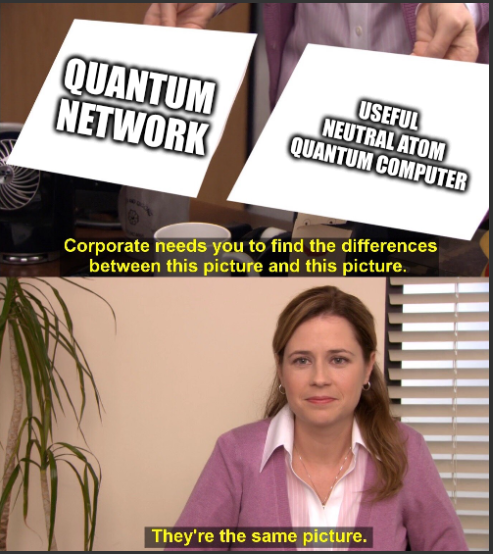